# TP5. Auto-encodeurs.
## UE apprentissage statistique et réseaux de neurones.
## Master mathématiques appliquées, statistique -  parcours data science.
## Frédéric Richard, AMU, 2025.

L'objectif de ce TP est d'apprendre à construire et à utiliser les auto-encodeurs. On travaillera sur la base MNIST. Dans un premier temps, on comparera des auto-encodeurs denses et convolutionnels. Puis, on appliquera les auto-encodeurs pour le débruitage d'images.

## Préambule.

**Déclaration des librairies et méthodes utiles au TP:**

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Préparation des données.**


Charger la base de données MNIST et préparer-la pour le traitement en pytorch en séparant les données d'apprentissage et de test. 

In [57]:
# Chargement et prétraitement des données MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 1. Auto-encodeurs denses.

On va définir plusieurs auto-encodeurs à couches denses en utilisant la classe **Module** de la librairie *torch.nn*.

#### 1.1. Modèle Dense n°1

Il s'agit d'un autoencodeur dont l'encodeur et le décodeur ne comporte qu'une seule couche dense. La couche cachée de l'auto-encodeur est de taille $K$. L'activation à la suite des couches denses est au choix. La taille de l'image en entrée, le paramètre $K$ et l'activation seront entrées en argument de la fonction qui définit l'auto-encodeur (voir ci-dessous).    

| **Partie**  | **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | --- | 
| | Input | - | (M, N) | - |
| Encodeur | Vectorisation | - | ..... | - |
| | Dense 1  | K cellules, activation |  ..... | ..... |
| Décodeur | Dense 2  | M x N cellules, activation sigmoïd  | ......  | ..... |
| | Remise en forme de l'image   | -  | (M, N) | - |


On pourra définir le modèle en remplissant le programme suivant:

In [58]:
# Définition de l'encodeur
class Encoder(nn.Module):
    def __init__(self, M, N, K, activation=nn.ReLU()):
        super(Encoder, self).__init__()
        self.M = M
        self.N = N
        self.K = K
        self.activation = activation
        
        self.fc = nn.Linear(M * N, K)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

# Définition du décodeur
class Decoder(nn.Module):
    def __init__(self, M, N, K, activation=nn.ReLU()):
        super(Decoder, self).__init__()
        self.M = M
        self.N = N
        self.K = K
        self.activation = activation
        
        self.fc = nn.Linear(K, M * N)
        self.sigmoid = nn.Sigmoid()  # Activation de sortie pour normaliser les pixels
    
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 1, self.M, self.N)  # Remise en forme de l'image
        return x

# Définition de l'auto-encodeur
class AutoEncoder(nn.Module):
    def __init__(self, im_shape, K, activation=nn.ReLU()):
        super(AutoEncoder, self).__init__()
        self.M = im_shape[0]
        self.N = im_shape[1]
        self.K = K
        
        self.encoder = Encoder(self.M, self.N, K, activation)
        self.decoder = Decoder(self.M, self.N, K, activation)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 1.2. Modèle Dense n°2.
   
On définira ensuite un auto-encodeur à plusieurs couches denses.

| **Partie**  | **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | --- | 
| | Input | - | (M, N) | - |
| Encodeur | Vectorisation | - | ......  | - |
| | Dense 1  | 128 cellules|  ......  | ......  |
|  | Activation         |  au choix | - | - |  
| | Dense 2  | K cellules|  ......  | ...... |
|  | Activation         |  au choix | - | - |  
| Décodeur | Dense 3  | 128 cellules| ......   | ...... |
|  | Activation         |  au choix | - | - |  
| | Dense 4  | M x N cellules | ......  |......  |
|  | Activation         |  sigmoïd | - | - |  
| | Remise en forme de l'image   | -  | (M, N) | - |

In [59]:
# Définition de l'encodeur du modèle Dense_2
class EncoderDense2(nn.Module):
    def __init__(self, M, N, K, activation=nn.ReLU()):
        super(EncoderDense2, self).__init__()
        self.M = M
        self.N = N
        self.K = K
        self.activation = activation
        
        self.fc1 = nn.Linear(M * N, 128)
        self.fc2 = nn.Linear(128, K)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        if self.activation:
            x = self.activation(x)
        x = self.fc2(x)
        if self.activation:
            x = self.activation(x)
        return x

# Définition du décodeur du modèle Dense_2
class DecoderDense2(nn.Module):
    def __init__(self, M, N, K, activation=nn.ReLU()):
        super(DecoderDense2, self).__init__()
        self.M = M
        self.N = N
        self.K = K
        self.activation = activation
        
        self.fc3 = nn.Linear(K, 128)
        self.fc4 = nn.Linear(128, M * N)
        self.sigmoid = nn.Sigmoid()  # Activation de sortie pour normaliser les pixels
    
    def forward(self, x):
        x = self.fc3(x)
        if self.activation:
            x = self.activation(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 1, self.M, self.N)  # Remise en forme de l'image
        return x

# Définition du modèle Dense_2
class AutoEncoderDense2(nn.Module):
    def __init__(self, im_shape, K, activation=nn.ReLU()):
        super(AutoEncoderDense2, self).__init__()
        self.M = im_shape[0]
        self.N = im_shape[1]
        self.K = K
        
        self.encoder = EncoderDense2(self.M, self.N, K, activation)
        self.decoder = DecoderDense2(self.M, self.N, K, activation)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Exercice 1**

1. Instancier
    - le modèle Dense_1 sans activation (None) en prenant une couche cachée de taille $K=64$.
    - le modèle Dense_1 avec une activation relu en prenant une couche cachée de taille $K=64$.
    - le modèle Dense_2 avec une activation relu en prenant une couche cachée de taille $K=64$.
2. Compléter les tableaux de description des modèles ainsi instanciés.
3. Comparer la complexité des modèles (en termes de nombre de paramètres).
4. Faire l'apprentissage des modèles.
5. Comparer leurs performances sur la base de test.
6. Visualiser quelques résultats en comparant l'image initiale et l'image reconstruite par auto-encodeur.



In [60]:
# Instanciation des modèles
im_shape = (28, 28)
K = 64

model_dense1_no_activation = AutoEncoder(im_shape, K, activation=None)
model_dense1_relu = AutoEncoder(im_shape, K, activation=nn.ReLU())
model_dense2_relu = AutoEncoderDense2(im_shape, K, activation=nn.ReLU())

| **Partie**  | **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | --- | 
| | Input | - | (M, N) | - |
| Encodeur | Vectorisation | - | M * N | - |
| | Dense 1  | K cellules, activation |  K | (M * N + 1) * K |
| Décodeur | Dense 2  | M x N cellules, activation sigmoïd  | M * N  | (K + 1) * (M * N) |
| | Remise en forme de l'image   | -  | (M, N) | - |


| **Partie**  | **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | --- | 
| | Input | - | (M, N) | - |
| Encodeur | Vectorisation | - | M * N  | - |
| | Dense 1  | 128 cellules|  128  | (M * N + 1) * 128  |
|  | Activation         |  au choix | - | - |  
| | Dense 2  | K cellules|  K  | (128 + 1) * K |
|  | Activation         |  au choix | - | - |  
| Décodeur | Dense 3  | 128 cellules| 128   | (K + 1) * 128 |
|  | Activation         |  au choix | - | - |  
| | Dense 4  | M x N cellules | M * N  | (128 + 1) * M * N  |
|  | Activation         |  sigmoïd | - | - |  
| | Remise en forme de l'image   | -  | (M, N) | - |

 ### **Modèle n°1 :**
- **Dense 1 (Encodeur)** :  
  $$ (M \times N + 1) \times K $$
- **Dense 2 (Décodeur)** :  
  $$ (K + 1) \times (M \times N) $$
- **Total paramètres Modèle 1** :  
  $$ (M \times N + 1) \times K + (K + 1) \times (M \times N) $$

En remplaçant par $ M = 28, N = 28, K = 64 $ :  
$$ (28 \times 28 + 1) \times 64 + (64 + 1) \times (28 \times 28) $$
$$ (785 \times 64) + (65 \times 784) = 50240 + 50960 = 101200 $$

---

### **Modèle n°2 :**
- **Dense 1 (Encodeur)** :  
  $$ (M \times N + 1) \times 128 $$
- **Dense 2 (Encodeur)** :  
  $$ (128 + 1) \times K $$
- **Dense 3 (Décodeur)** :  
  $$ (K + 1) \times 128 $$
- **Dense 4 (Décodeur)** :  
  $$ (128 + 1) \times (M \times N) $$
- **Total paramètres Modèle 2** :  
  $$ (M \times N + 1) \times 128 + (128 + 1) \times K + (K + 1) \times 128 + (128 + 1) \times (M \times N) $$

En remplaçant par $ M = 28, N = 28, K = 64 $ :  
$$ (785 \times 128) + (129 \times 64) + (65 \times 128) + (129 \times 784) $$
$$ 100480 + 8256 + 8320 + 101136 = 218192 $$

---

#### Le modèle n°2 est donc environ deux fois plus complexe que le 1.

In [61]:
# Définition de la fonction de perte et de l'optimiseur
def train_model(model, train_loader, num_epochs=5, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for images, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    print("Entraînement terminé.")

# Entraînement des modèles
print("Entraînement du modèle Dense 1 sans activation...")
train_model(model_dense1_no_activation, train_loader)

print("Entraînement du modèle Dense 1 avec activation ReLU...")
train_model(model_dense1_relu, train_loader)

print("Entraînement du modèle Dense 2 avec activation ReLU...")
train_model(model_dense2_relu, train_loader)

Entraînement du modèle Dense 1 sans activation...
Epoch [1/5], Loss: 0.0158
Epoch [2/5], Loss: 0.0067
Epoch [3/5], Loss: 0.0044
Epoch [4/5], Loss: 0.0043
Epoch [5/5], Loss: 0.0035
Entraînement terminé.
Entraînement du modèle Dense 1 avec activation ReLU...
Epoch [1/5], Loss: 0.0197
Epoch [2/5], Loss: 0.0093
Epoch [3/5], Loss: 0.0095
Epoch [4/5], Loss: 0.0084
Epoch [5/5], Loss: 0.0071
Entraînement terminé.
Entraînement du modèle Dense 2 avec activation ReLU...
Epoch [1/5], Loss: 0.0193
Epoch [2/5], Loss: 0.0123
Epoch [3/5], Loss: 0.0103
Epoch [4/5], Loss: 0.0086
Epoch [5/5], Loss: 0.0083
Entraînement terminé.


In [62]:
# Fonction pour évaluer un modèle sur la base de test
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad(): 
        for images, _ in test_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader) 
    return avg_loss

# Évaluation des modèles sur la base de test
print("Évaluation du modèle Dense 1 sans activation...")
loss_dense1_no_activation = evaluate_model(model_dense1_no_activation, test_loader)
print(f"Perte sur la base de test (Dense 1 sans activation): {loss_dense1_no_activation:.4f}")

print("Évaluation du modèle Dense 1 avec activation ReLU...")
loss_dense1_relu = evaluate_model(model_dense1_relu, test_loader)
print(f"Perte sur la base de test (Dense 1 avec activation ReLU): {loss_dense1_relu:.4f}")

print("Évaluation du modèle Dense 2 avec activation ReLU...")
loss_dense2_relu = evaluate_model(model_dense2_relu, test_loader)
print(f"Perte sur la base de test (Dense 2 avec activation ReLU): {loss_dense2_relu:.4f}")

Évaluation du modèle Dense 1 sans activation...
Perte sur la base de test (Dense 1 sans activation): 0.0039
Évaluation du modèle Dense 1 avec activation ReLU...
Perte sur la base de test (Dense 1 avec activation ReLU): 0.0067
Évaluation du modèle Dense 2 avec activation ReLU...
Perte sur la base de test (Dense 2 avec activation ReLU): 0.0085


Les trois modèles sont assez performants, le modèle n°1 sans activation est le plus performant (0.0039 de perte), légèrement devant ce même modèle avec activation (0.0067) et le modèle n°2 (0.0085).

Visualisation des reconstructions pour le modèle Dense 1 sans activation...


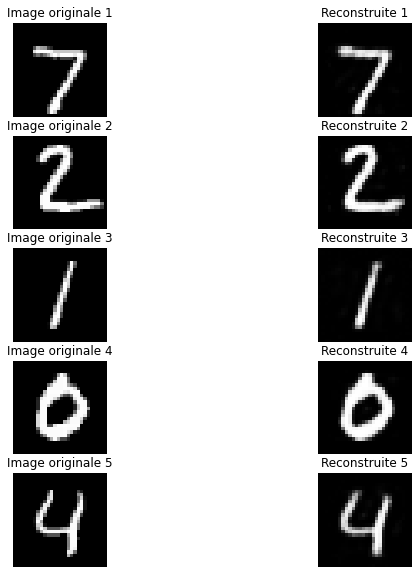

Visualisation des reconstructions pour le modèle Dense 1 avec activation ReLU...


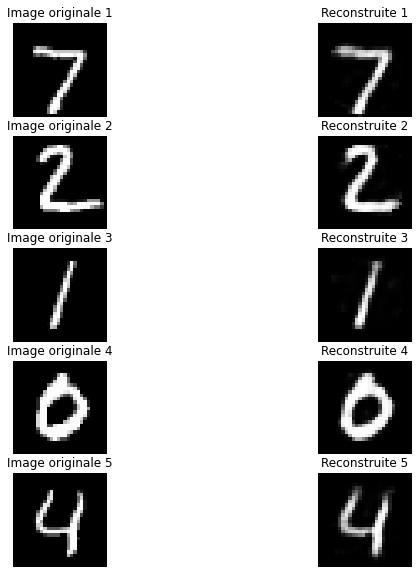

Visualisation des reconstructions pour le modèle Dense 2 avec activation ReLU...


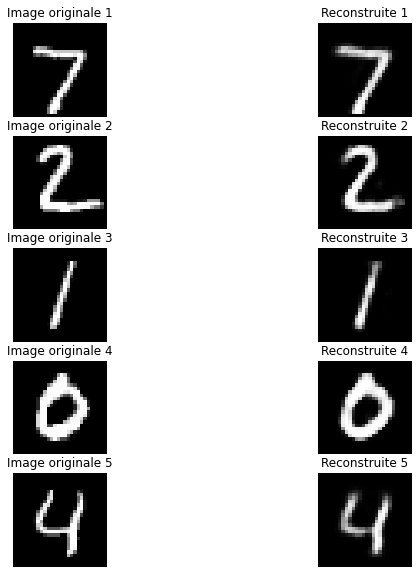

In [63]:
# Fonction pour afficher les images
def visualize_reconstruction(model, test_loader, num_images=5):
    model.eval() 
    images_to_show = []
    reconstructed_images = []

    with torch.no_grad():
        for images, _ in test_loader:
            outputs = model(images)
            images_to_show.append(images)
            reconstructed_images.append(outputs)
            if len(images_to_show) >= num_images:
                break

    # Sélectionner quelques images à afficher
    images_to_show = torch.cat(images_to_show, dim=0)[:num_images]
    reconstructed_images = torch.cat(reconstructed_images, dim=0)[:num_images]

    # Affichage
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))

    for i in range(num_images):
        # Afficher l'image originale
        ax = axes[i, 0]
        ax.imshow(images_to_show[i].squeeze(), cmap='gray')
        ax.set_title(f"Image originale {i+1}")
        ax.axis('off')

        # Afficher l'image reconstruite
        ax = axes[i, 1]
        ax.imshow(reconstructed_images[i].squeeze().cpu().numpy(), cmap='gray')
        ax.set_title(f"Reconstruite {i+1}")
        ax.axis('off')

    plt.show()

# Visualisation des résultats pour le modèle Dense 1 sans activation
print("Visualisation des reconstructions pour le modèle Dense 1 sans activation...")
visualize_reconstruction(model_dense1_no_activation, test_loader)

# Visualisation des résultats pour le modèle Dense 1 avec activation ReLU
print("Visualisation des reconstructions pour le modèle Dense 1 avec activation ReLU...")
visualize_reconstruction(model_dense1_relu, test_loader)

# Visualisation des résultats pour le modèle Dense 2 avec activation ReLU
print("Visualisation des reconstructions pour le modèle Dense 2 avec activation ReLU...")
visualize_reconstruction(model_dense2_relu, test_loader)


On constate bien ce que nous indiquaient les valeurs de perte, les images reconstruites du modèles n°1 sont légèrement meilleures que celles du n°2.

### 2. Auto-encodeurs convolutionnels.

On s'intéresse maintenant à un auto-encodeur à couches de convolution défini comme suit.

| **Partie** | **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | --- | 
| | Input | - | (M, N) | - | 
| Encodeur | Convolution 2D n°1 | 16 filtres de taille 3 x 3, stride=2, padding=1|  ..... | ..... |
|  | Convolution 2D n°1 | 16 filtres de taille 3 x 3, stride=2, padding=1 |  ..... | ..... |
|  | Activation         |  relu | - | - |  
|  | Convolution 2D n°2 | 32 filtres de taille 3 x 3, stride=2, padding=1 |  ..... | ..... |
|  | Activation         |  relu | - | - |  
|  | Convolution 2D n°3 | 64 filtres de taille 7 x 7, stride=1, padding=0 |  ..... | ..... |
| Décodeur | Convolution transposée 2D n°1 |  64 filtres de taille 7 x 7, stride=1, padding=0 |  ..... | ..... |
|  | Activation         |  relu | - | - |  
|  | Convolution transposée 2D n°2 | 32 filtres de taille 3 x 3, stride=2, padding=1, output_padding=1 |  ..... | ..... |
|  | Activation         |  relu | - | - |  
|  | Convolution transposée 2D n°3 | 16 filtres de taille 3 x 3, stride=2, padding=1, output_padding=1 |  ..... | ..... |
|  | Activation         |  sigmoïd | - | - |  
    



**Exercice 2**

1. Instancier le modèle.
2. Compléter le tableau de description du modèle.
3. Calculer la complexité du modèle et la comparer avec celles des modèles à couches denses.
4. Comparer la taille de la couche cachée du modèle avec celles des modèles à couches denses.
5. Faire l'apprentissage du modèle.
6. Comparer ses performances avec celles des modèles à couches denses sur la base de test.
7. Visualiser quelques résultats.

In [64]:
# Définition de l'auto-encodeur convolutionnel
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, groups=1),  # Convolution 2D n°1
            nn.ReLU(),  # Activation ReLU
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, groups=16),  # Convolution 2D n°2
            nn.ReLU(),  # Activation ReLU
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0, groups=32)   # Convolution 2D n°3
        )
        
        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0, groups=32),  # Convolution transposée 2D n°1
            nn.ReLU(),  # Activation ReLU
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, groups=16),  # Convolution transposée 2D n°2
            nn.ReLU(),  # Activation ReLU
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1, groups=1),  # Convolution transposée 2D n°3
            nn.Sigmoid()  # Activation Sigmoid
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instanciation du modèle
model_conv_autoencoder = ConvAutoEncoder()

In [65]:
from torchsummary import summary

# Affichage de la complexité du modèle
summary(model_conv_autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]             320
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]           3,200
   ConvTranspose2d-6             [-1, 32, 7, 7]           3,168
              ReLU-7             [-1, 32, 7, 7]               0
   ConvTranspose2d-8           [-1, 16, 14, 14]             304
              ReLU-9           [-1, 16, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             145
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

2 : 
| **Partie** | **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | --- | 
| | Input | - | (M, N) | - | 
| Encodeur | Convolution 2D n°1 | 16 filtres de taille 3 x 3, stride=2, padding=1|  (16, M/2, N/2) | (3 * 3 + 1) * 16 = 160|
|  | Activation         |  relu | - | - |  
|  | Convolution 2D n°2 | 32 filtres de taille 3 x 3, stride=2, padding=1 | (32, M/4, N/4) | (3 * 3 + 1) * 32 = 320|
|  | Activation         |  relu | - | - |  
|  | Convolution 2D n°3 | 64 filtres de taille 7 x 7, stride=1, padding=0 | (64, M/4, N/4) | (7 * 7 + 1) * 64 = 3200|
| Décodeur | Convolution transposée 2D n°1 |  64 filtres de taille 7 x 7, stride=1, padding=0 | (32, M/4, N/4) | 64 * 7 * 7 + 32 = 3168|
|  | Activation         |  relu | - | - |  
|  | Convolution transposée 2D n°2 | 32 filtres de taille 3 x 3, stride=2, padding=1, output_padding=1 | (16, M/2, N/2) | 32 * 3 * 3 + 16 = 304 |
|  | Activation         |  relu | - | - |  
|  | Convolution transposée 2D n°3 | 16 filtres de taille 3 x 3, stride=2, padding=1, output_padding=1 |  (M, N) | 16 * 3 * 3 + 1 = 145 |
|  | Activation         |  sigmoïd | - | - |  

3 : La complexité du modèle est de 7 297 paramètres soit environ 14 fois moins que le modèle n°1 et environ 30 fois moins que le modèle n°2, il est donc beaucoup plus efficace.

4 : La taille de la couche cachée des modèle n°1 et n°2 est K que l'on a choisi à 64 tout comme dans le modèle convolutionnel. Les trois modèles ont donc la même taille de couche cachée.

In [66]:
# Entraînement du modèle
print("Entraînement du modèle convolutionnel...")
train_model(model_conv_autoencoder, train_loader)

Entraînement du modèle convolutionnel...
Epoch [1/5], Loss: 0.0616
Epoch [2/5], Loss: 0.0484
Epoch [3/5], Loss: 0.0417
Epoch [4/5], Loss: 0.0369
Epoch [5/5], Loss: 0.0389
Entraînement terminé.


In [67]:
# Évaluation du modèle sur la base de test
print("Évaluation du modèle convolutionnel...")
loss_convolutionnel = evaluate_model(model_conv_autoencoder, test_loader)
print(f"Perte sur la base de test (Convolutionnel): {loss_convolutionnel:.4f}")

Évaluation du modèle convolutionnel...
Perte sur la base de test (Convolutionnel): 0.0348


La perte du modèle convolutionnel est bien supérieures à celles des modèle n°1 et n°2 (0.0348 contre entre 0.0039 et 0.0085 soit 4 à 10 fois plus de perte).

Visualisation des reconstructions pour le modèle convolutionnel...


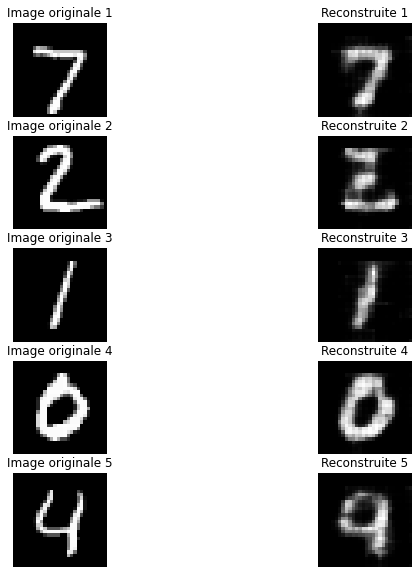

In [68]:
# Visualisation des résultats pour le modèle convolutionnel
print("Visualisation des reconstructions pour le modèle convolutionnel...")
visualize_reconstruction(model_conv_autoencoder, test_loader)

La visualisation des images reconstruites confirment bien ce qu'indiquaient les valeurs de perte, les images reconstruites par le modèle convolutionnel sont bien plus éloignées des images originales que celles reconstruites par les modèles n°1 et n°2.

### 2. Application au débruitage d'images.

Les auto-encodeurs peuvent être utilisés pour débruiter les images. Pour cela, on fait l'apprentissage de l'auto-encodeur en l'appliquant à des images bruitées et faisant en sorte de rapprocher leurs images de sortie des images non bruitées. Le modèle apprend ainsi à produire une image débruitée à partir de l'image bruitée. Son action devient alors celle d'un filtre.

**Exercice 3**

1. Créer une base d'exemples $(x_i, y_i)$ où $y_i$ est une image de la base MNIST et $x_i = y_i + n_i$ où $n_i$ est un bruit additif gaussien d'espérance 0 et de variance fixée.
2. Faire l'apprentissage de l'auto-encodeur sur cette base d'exemples en prenant $x_i$ en entrée et minimisant le critère des moindres carrés entre la sortie de l'auto-encodeur et l'image $y_i$.
3. Evaluer la similarité entre les images sans bruit et les images débruités sur une base de test.
4. Visualiser l'effet du filtre quelques images bruitées. 

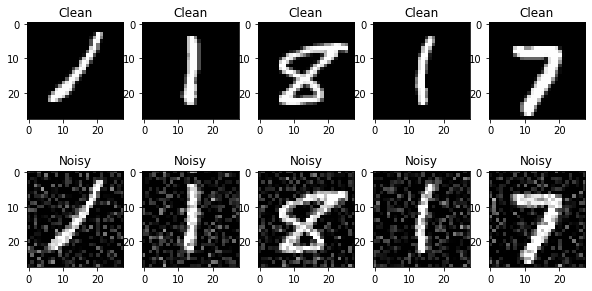

In [69]:
noise_std = 0.2  # Écart-type du bruit

# Fonction pour ajouter du bruit
def add_noise(images, noise_std):
    noise = torch.randn_like(images) * noise_std
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)  # On sature entre 0 et 1 pour des pixels valides

# Exemple d'utilisation
for clean_images, _ in train_loader:
    noisy_images = add_noise(clean_images, noise_std)
    break  # Juste pour visualiser un batch

# Visualisation
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(clean_images[i].squeeze(), cmap='gray')
    plt.title("Clean")
    plt.subplot(2, 5, i+6)
    plt.imshow(noisy_images[i].squeeze(), cmap='gray')
    plt.title("Noisy")
plt.show()

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entraînement du modèle
def train(model, train_loader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    for epoch in range(epochs):
        total_loss = 0
        for clean_imgs, _ in train_loader:
            clean_imgs = clean_imgs.to(device)
            noisy_imgs = add_noise(clean_imgs, noise_std).to(device)
            
            optimizer.zero_grad()
            outputs = model(noisy_imgs)  
            loss = criterion(outputs, clean_imgs)  
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * clean_imgs.size(0)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}")

train(model_conv_autoencoder, train_loader, epochs=10)

Epoch 1/10, Loss: 0.0368
Epoch 2/10, Loss: 0.0352
Epoch 3/10, Loss: 0.0344
Epoch 4/10, Loss: 0.0337
Epoch 5/10, Loss: 0.0332
Epoch 6/10, Loss: 0.0310
Epoch 7/10, Loss: 0.0296
Epoch 8/10, Loss: 0.0283
Epoch 9/10, Loss: 0.0269
Epoch 10/10, Loss: 0.0259


In [71]:
# Evaluation du modèle
def evaluate_denoising(model, test_loader, noise_std=0.2):
    model.eval()
    total_mse = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for clean_images, _ in test_loader:
            noisy_images = add_noise(clean_images, noise_std).to(device)
            clean_images = clean_images.to(device)
            denoised_images = model(noisy_images) 
            loss = criterion(denoised_images, clean_images)
            total_mse += loss.item() * clean_images.size(0)
    
    avg_mse = total_mse / len(test_loader.dataset)
    return avg_mse

test_loss = evaluate_denoising(model_conv_autoencoder, test_loader, noise_std=0.2)
print(f"MSE moyen sur le test: {test_loss:.4f}")

MSE moyen sur le test: 0.0251


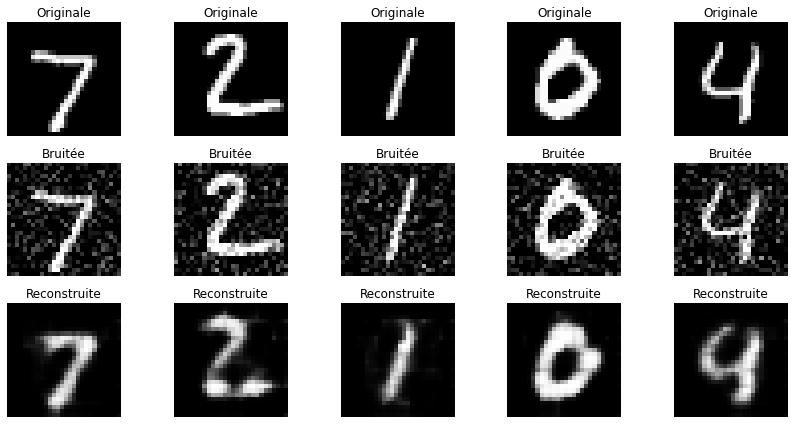

In [72]:
# Récupération d'un batch de test
model_conv_autoencoder.eval()
with torch.no_grad():
    clean_images, _ = next(iter(test_loader))
    noisy_images = add_noise(clean_images, noise_std=0.2)
    denoised_images = model_conv_autoencoder(noisy_images.to(device)).cpu()

# Fonction pour afficher les images
def imshow(img, title=None):
    img = img.squeeze()  
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Affichage des résultats pour 5 exemples
plt.figure(figsize=(12, 6))
for i in range(5):
    # Image originale
    plt.subplot(3, 5, i+1)
    imshow(clean_images[i], "Originale")
    
    # Image bruitée
    plt.subplot(3, 5, i+6)
    imshow(noisy_images[i], "Bruitée")
    
    # Image reconstruite
    plt.subplot(3, 5, i+11)
    imshow(denoised_images[i], "Reconstruite")

plt.tight_layout()
plt.show()